<a href="https://colab.research.google.com/github/sttesta3/7506R-1C2024-GRUPO08/blob/santiago/Regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión

En esta etapa se busca predecir el precio de la propiedad utilizando dos modelos diferentes.
Para todos los modelos se pide realizar las tareas de ingeniería de características necesarias para trabajar con cada algoritmo (encoding, normalización, etc).

## Librerias y Funciones

Importamos las librerias a utilizar

In [194]:
# General libs
import pandas as pd
import numpy as np

#Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt

#Modelos
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn import svm


# KFold cross validation
from sklearn import metrics
from sklearn.model_selection import cross_val_score


Funciones utiles a utilizar a lo largo de la Notebook

In [195]:
# Esta funcion se encarga de imprimir las metricas R2 y RMSE de un metodo al ser invocada
# ademas, retorna el valor de rmse pues lo usamos en las graficas de nuestros metodos.
def mostrar_metricas(y_test, y_pred):
  r2 = round(metrics.r2_score(y_test, y_pred), 4)
  rmse = round(metrics.mean_squared_error(y_test, y_pred, squared=False), 4)

  print(f'R2 = {r2}')
  print(f'RMSE = {rmse}')

  return r2, rmse

In [196]:
# Esta funcion se encarga de graficar un versus entre los valores reales y los
# predichos por nuestro modelo. Ademas de graficar el valor que dio la metrica
# RMSE
def plotear_precios(datos_reales, datos_predichos, rmse, titulo_reales, titulo_predichos):
    # Calcula el valor máximo para el eje x
    maximo_x = max(max(datos_reales), max(datos_predichos))

    # Configura el tamaño y la disposición de las subgráficas
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Graficar datos reales
    sns.histplot(datos_reales, ax=axs[0])
    axs[0].set_title(titulo_reales)
    axs[0].set_xlabel("Precio")
    axs[0].set_ylabel("Observaciones")
    axs[0].set_xlim(0, maximo_x)  # Establece el límite máximo en el eje x

    # Graficar datos predichos
    sns.histplot(datos_predichos, ax=axs[1])
    axs[1].set_title(titulo_predichos)
    axs[1].set_xlabel("Precio")
    axs[1].set_ylabel("Observaciones")
    axs[1].set_xlim(0, maximo_x)  # Establece el límite máximo en el eje x

    # Agregar líneas verticales rojas en intervalos determinados por el RMSE
    for ax in axs:
        for i in range(1, int(maximo_x // rmse)):
            ax.axvline(i * rmse, color="red", linestyle="dotted")

    # Ajustar el espacio entre las subgráficas para que no se superpongan
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

In [197]:
# Esta funcion imprime una comparaciones entre las metricas obtenidas por
# el modelo trabajando con los datasets de train y de test
def imprimir_comparacion_metricas(r2_test, rmse_test, r2_train, rmse_train):
  print("Resultados contra los datos de test:")
  print(f"  > R2 = {r2_test}")
  print(f"  > RMSE = {rmse_test}")

  print("\nResultados contra los datos de train:")
  print(f"  > R2 = {r2_train}")
  print(f"  > RMSE = {rmse_train}")

  return None

## Preparación de data

Cargamos nuestros dataset filtrado.

In [198]:
ruta = "https://raw.githubusercontent.com/sttesta3/7506R-1C2024-GRUPO08/fede/datasets/"
df_target = pd.read_csv(ruta + "ds_filtrado.csv")

Obtenemos las features que vamos a utilizar en regresion

In [199]:
# Nos quedamos unicamente con los features que nos interesan.
df_target = df_target.copy()[[
    'latitud',
    'longitud',
    'property_rooms',
    'property_bedrooms',
    'property_surface_total',
    'property_price',
    'property_surface_covered',
    'property_type'
    ]]

# Convertimos la variable cualitatita "property_price" en forma numerica por medio de One Hot Encoding
df_target = pd.get_dummies(df_target,columns=["property_type"], drop_first=True)

# Hacemos una lista con las features que usaremos para regresion
features_regresion = list(df_target.columns)
features_regresion.remove("property_price")

# Selecciono variables regresoras y a predecir
x = df_target[features_regresion].values
y = df_target.property_price

# Separacion Train/test
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.2,  # 80/20
                                                    random_state = 7) # semilla

# Escalamos los datos
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Aclaraciones pertinentes

Al momento de elegir los mejores hiperparametros para nuestros Modelos vamos a utilizar Random Search Cross Validation utilizando como scoring la metrica $R^2$

El coeficiente de determinación ($R^2$) es una métrica utilizada para evaluar la calidad de un modelo de regresión. Esta métrica indica cuánta varianza en la variable de respuesta es explicada por el modelo.

$R^2$ puede tomar valores entre 0 y 1, y su interpretación es la siguiente:

- $R^2 = 0$ ▶ indica que el modelo no explica ninguna variabilidad en la variable de respuesta alrededor de su media.
- $R^2 = 1$ ▶ indica que el modelo explica toda la variabilidad en la variable de respuesta alrededor de su media y que se ajusta perfectamente a los datos.

En general, cuanto más cercano esté el $R^2$ a 1, mejor será el ajuste del modelo a los datos. Sin embargo, el $R^2$ por sí solo no proporciona información sobre si el modelo es adecuado o no.

## Modelo 1: KNN

### Buscamos los mejores hiperparametros

In [200]:
# Cantidad de combinaciones que quiero probar
n = 15

# Cantidad de splits para el Cross Validation
cantidad_folds = 5

# Conjunto de parámetros que quiero usar
grilla_de_parametros_knn = {
    'leaf_size': list(range(1, 40)),
    'n_neighbors': list(range(2, 40)),
    'p': [1, 2, 3, 4],
    'weights': ['uniform', 'distance']
}

# Kfold estratificado
kfoldcv = KFold(n_splits = cantidad_folds)

# Clasificador
knn_model = KNeighborsRegressor()

# Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = knn_model,
                              param_distributions = grilla_de_parametros_knn,
                              scoring = 'r2',
                              cv = kfoldcv,
                              n_jobs = -1,
                              n_iter = n,
                              random_state = 23)

# Busco los hiperparamtros que optimizan R2 Score
randomcv.fit(x_train, y_train);

# Mejor métrica
print(randomcv.best_score_)
mejores_parametros_knn = randomcv.best_params_
print(mejores_parametros_knn)

0.8248230022663352
{'weights': 'distance', 'p': 1, 'n_neighbors': 21, 'leaf_size': 34}


### Creamos el modelo, entrenamos y predecimos valores

Ahora que ya tenemos los mejores parametros procedemos a armar nuestro modelo y ponerlo a prueba

In [201]:
# Creo el modelo y lo entreno
knn_model = KNeighborsRegressor().set_params(**mejores_parametros_knn)
knn_model.fit(x_train, y_train)

# Realizamos la predicción
y_pred = knn_model.predict(x_test)

Evaluamos las metricas del modelo con los datos de test

In [202]:
r2_test, rmse_test = mostrar_metricas(y_test, y_pred)

R2 = 0.8395
RMSE = 25308.5719


Grafico los precios reales de mi conjunto de test (y_test) vs los precios predichos por mi modelo en base al conjunto de test (x_test)

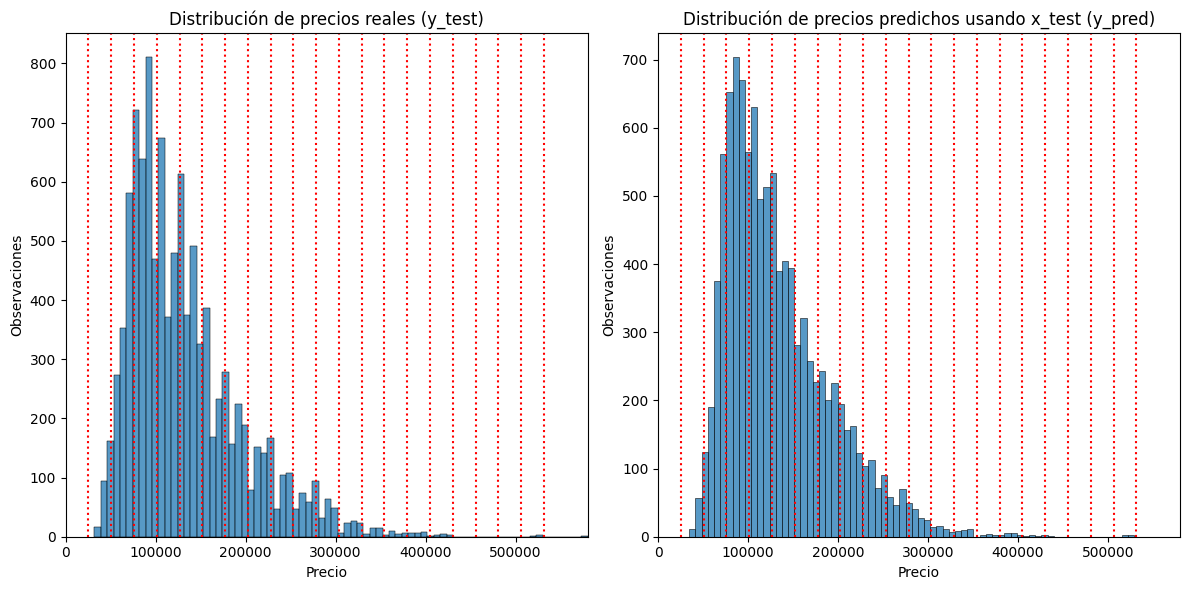

In [203]:
plotear_precios(datos_reales = y_test,
                datos_predichos = y_pred,
                rmse = rmse_test,
                titulo_reales = "Distribución de precios reales (y_test)",
                titulo_predichos = "Distribución de precios predichos usando x_test (y_pred)")

### Evaluamos metricas con datos de train

Vamos a hacer que nuestro modelo prediga precios, pero usando el set de entrenamiento a ver que tal funciona.

In [204]:
y_train_pred = knn_model.predict(x_train)
r2_train, rmse_train = mostrar_metricas(y_train, y_train_pred)

R2 = 0.9947
RMSE = 4506.4962


Grafico los precios reales de mi conjunto de entrenamiento (y_train) vs los precios predichos por mi modelo en base al conjunto de entrenamiento (x_train)

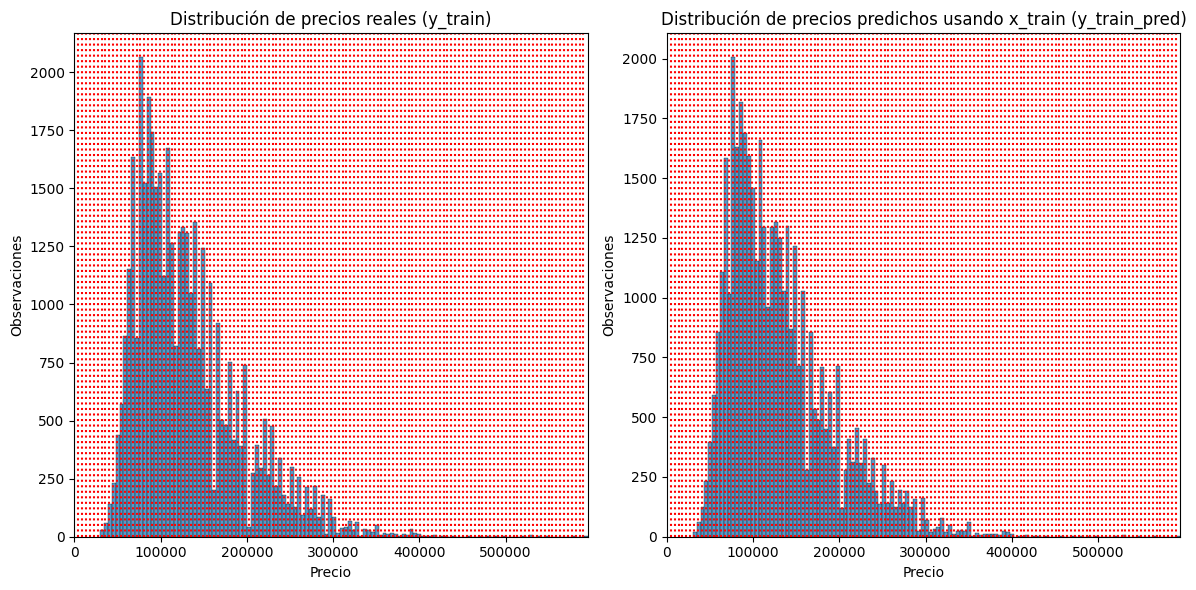

In [205]:
plotear_precios(datos_reales = y_train,
                datos_predichos = y_train_pred,
                rmse = rmse_train,
                titulo_reales = "Distribución de precios reales (y_train)",
                titulo_predichos = "Distribución de precios predichos usando x_train (y_train_pred)")

### Comparamos los resultados con las metricas en train y test

In [206]:
imprimir_comparacion_metricas(r2_test, rmse_test, r2_train, rmse_train)

Resultados contra los datos de test:
  > R2 = 0.8395
  > RMSE = 25308.5719

Resultados contra los datos de train:
  > R2 = 0.9947
  > RMSE = 4506.4962


Resulta evidente que el modelo esta realizando un severo overfitting, lo cual salta a la vista tanto por el elevado valor de sus metricas al trabajar con los datos de train, como asi tambien por la considerable variacion de dichas metricas al enfrentarse al conjunto de test.

## Modelo 2: XGBoost

### Buscamos los mejores hiperparametros

In [207]:
# Cantidad de combinaciones que quiero probar
n = 15

# Cantidad de splits para el Cross Validation
cantidad_folds = 5

# Conjunto de parámetros a usar
grilla_de_parametros_xgb = {
    "learning_rate": np.linspace(0.05, 0.5, 50),
    "gamma": [0, 1, 2],
    "max_depth": list(range(2, 10)),
    "subsample": np.linspace(0, 1, 20),
    "lambda": [0, 1, 2],
    "alpha" : [0, 1, 2],
    "n_estimators": list(range(10, 161, 10))
    }

# Kfold
kfoldcv = KFold(n_splits = cantidad_folds)

# Clasificador
xgboost = xgb.XGBRegressor(random_state = 23)

# Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = xgboost,
                              param_distributions = grilla_de_parametros_xgb,
                              scoring = 'r2',
                              cv = kfoldcv,
                              n_jobs = -1,
                              n_iter = n,
                              random_state = 23)

# Busco los hiperparametros que optimizan el R2 Score
randomcv.fit(x_train, y_train);

# Mejor métrica
print(randomcv.best_score_)
mejores_parametros_xgb = randomcv.best_params_
print(mejores_parametros_xgb)

0.8040997318215319
{'subsample': 0.6842105263157894, 'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.20612244897959187, 'lambda': 1, 'gamma': 1, 'alpha': 2}


### Creamos el modelo, entrenamos y predecimos valores

Ahora que ya tenemos los mejores parametros procedemos a armar nuestro modelo y ponerlo a prueba

In [208]:
# Creo el modelo y lo entreno
xgb_model = xgb.XGBRegressor(random_state = 23).set_params(**mejores_parametros_xgb)
xgb_model.fit(x_train, y_train)

# Realizamos la predicción
y_pred = xgb_model.predict(x_test)

Evaluamos las metricas del modelo con los datos de test

In [209]:
r2_test, rmse_test = mostrar_metricas(y_test, y_pred)

R2 = 0.809
RMSE = 27610.2765


Grafico los precios reales de mi conjunto de test (y_test) vs los precios predichos por mi modelo en base al conjunto de test (x_test)

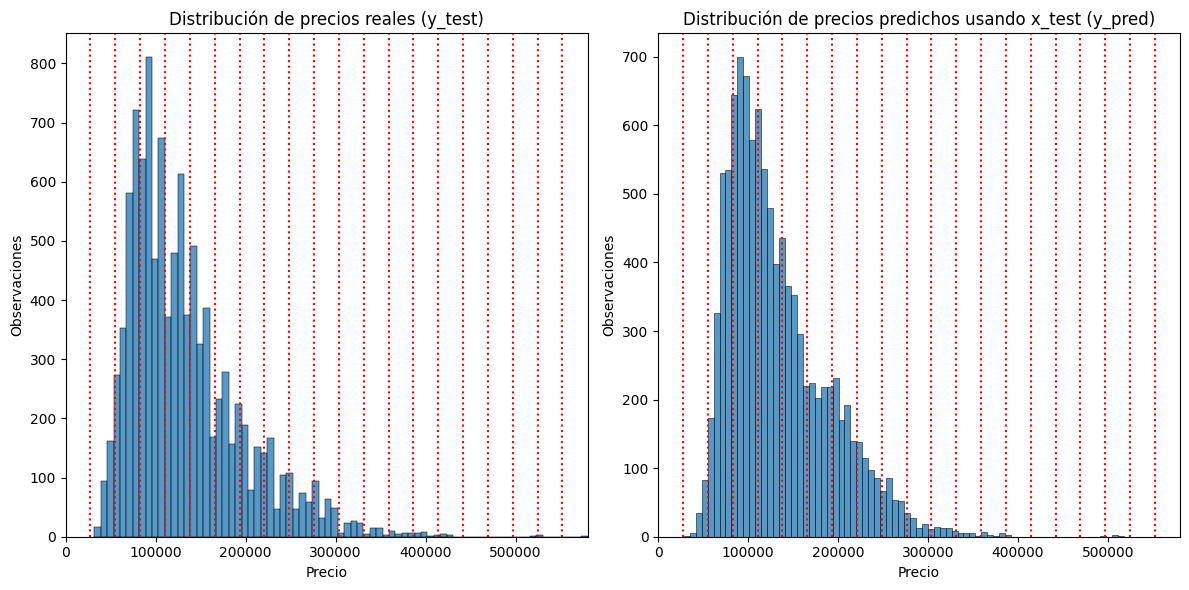

In [210]:
plotear_precios(datos_reales = y_test,
                datos_predichos = y_pred,
                rmse = rmse_test,
                titulo_reales = "Distribución de precios reales (y_test)",
                titulo_predichos = "Distribución de precios predichos usando x_test (y_pred)")

### Evaluamos metricas con datos de train

Vamos a hacer que nuestro modelo prediga precios, pero usando el set de entrenamiento a ver que tal funciona.

In [211]:
y_train_pred = xgb_model.predict(x_train)
r2_train, rmse_train = mostrar_metricas(y_train, y_train_pred)

R2 = 0.866
RMSE = 22726.6807


Grafico los precios reales de mi conjunto de entrenamiento (y_train) vs los precios predichos por mi modelo en base al conjunto de entrenamiento (x_train)

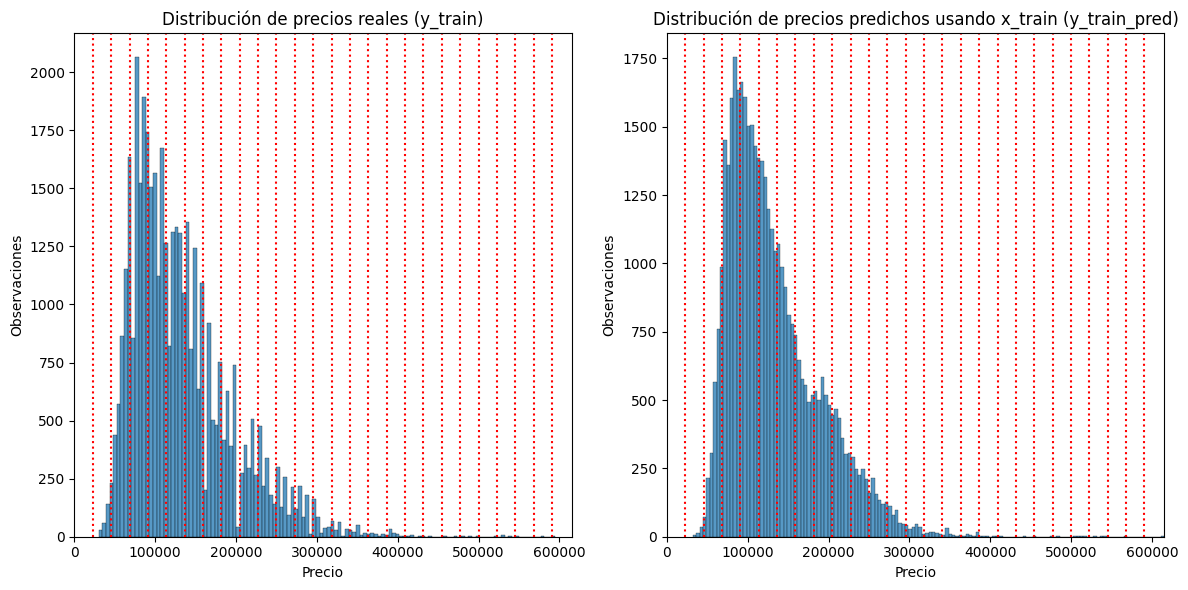

In [212]:
plotear_precios(datos_reales = y_train,
                datos_predichos = y_train_pred,
                rmse = rmse_train,
                titulo_reales = "Distribución de precios reales (y_train)",
                titulo_predichos = "Distribución de precios predichos usando x_train (y_train_pred)")

### Comparamos los resultados con las metricas en train y test

In [213]:
imprimir_comparacion_metricas(r2_test, rmse_test, r2_train, rmse_train)

Resultados contra los datos de test:
  > R2 = 0.809
  > RMSE = 27610.2765

Resultados contra los datos de train:
  > R2 = 0.866
  > RMSE = 22726.6807


Podemos ver que en este modelo tenemos una clara mejora con respecto a KNN, ya que no solo tenemos una metrica considerablemente mas alta en el manejo de los datos de test, sino que tambien tenemos resultados mucho mas equilibrados para las metricas al comparar los resultados en test y train.

## Modelo 3: Support Vector Machines

Decidimos implementar un modelo de SVM utilizando la libreria `svm.LinearSVR`, con la cual se puede generar un modelo de SVM con un Kernel lineal.

Optamos por esta opción, dado que entrenar un SVM con otro tipo de Kernel conllevaba demasiado tiempo y recursos.

### Buscamos los mejores hiperparametros

In [214]:
# Cantidad de combinaciones de parametros a probar
n = 15

# Cantidad de splits para el Cross Validation
cantidad_folds = 5

# Conjunto de parámetros a probar
grilla_de_parametros_svm = {
    "C": [100, 10, 1, 0.75, 0.5],
    "loss": ["epsilon_insensitive", "squared_epsilon_insensitive"],
    "max_iter": list(range(1000, 10000, 2000))
    }

# Kfold
kfoldcv = KFold(n_splits = cantidad_folds)

#Regresor
svm_model = svm.LinearSVR(random_state = 7)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = svm_model,
                              param_distributions = grilla_de_parametros_svm,
                              scoring = 'r2',
                              cv = kfoldcv,
                              n_jobs = -1,
                              n_iter = n,
                              random_state = 23)

#Busco los hiperparametros que optimizan R2 Score
randomcv.fit(x_train, y_train);

#Mejor métrica
print(randomcv.best_score_)
mejores_parametros_svm = randomcv.best_params_
print(mejores_parametros_svm)

0.635906753619597
{'max_iter': 7000, 'loss': 'squared_epsilon_insensitive', 'C': 10}


### Creamos el modelo, entrenamos y predecimos valores

Ahora que ya tenemos los mejores parametros procedemos a armar nuestro modelo y ponerlo a prueba

In [215]:
# Creo el modelo y lo entreno
svm_model = svm.LinearSVR(random_state = 7).set_params(**mejores_parametros_svm)
svm_model.fit(x_train, y_train)

# Realizamos la predicción
y_pred = svm_model.predict(x_test)

Evaluamos las metricas del modelo con los datos de test

In [216]:
r2_test, rmse_test = mostrar_metricas(y_test, y_pred)

R2 = 0.6233
RMSE = 38775.6268


Grafico los precios reales de mi conjunto de test (y_test) vs los precios predichos por mi modelo en base al conjunto de test (x_test)

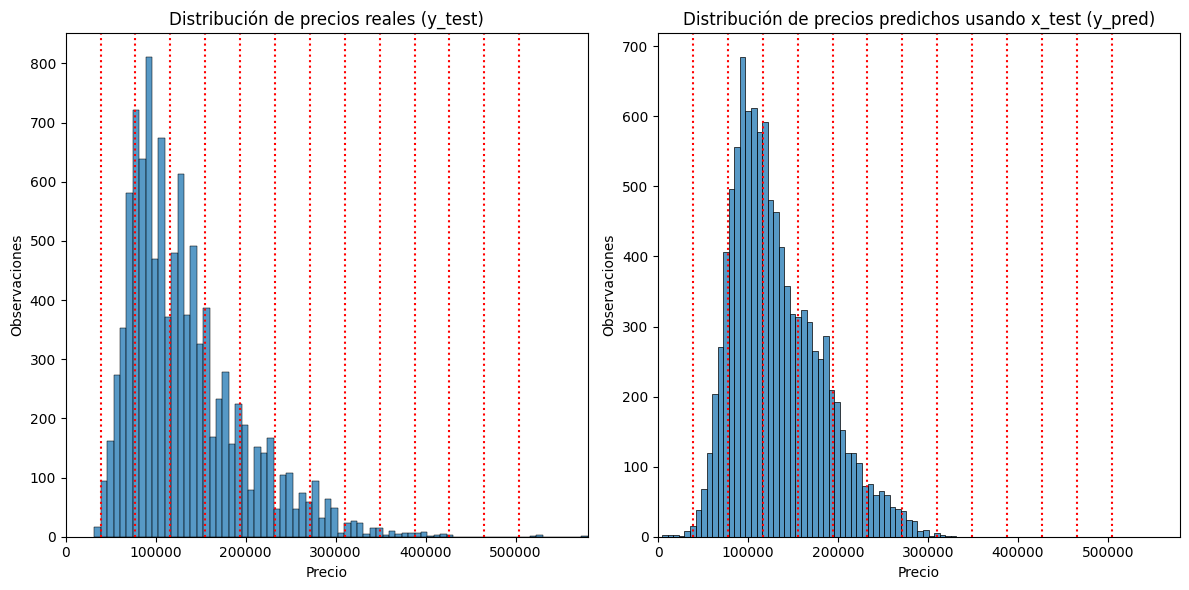

In [217]:
plotear_precios(datos_reales = y_test,
                datos_predichos = y_pred,
                rmse = rmse_test,
                titulo_reales = "Distribución de precios reales (y_test)",
                titulo_predichos = "Distribución de precios predichos usando x_test (y_pred)")

### Evaluamos metricas con datos de train

Vamos a hacer que nuestro modelo prediga precios, pero usando el set de entrenamiento a ver que tal funciona.

In [218]:
y_train_pred = svm_model.predict(x_train)
r2_train, rmse_train = mostrar_metricas(y_train, y_train_pred)

R2 = 0.636
RMSE = 37451.6264


Grafico los precios reales de mi conjunto de entrenamiento (y_train) vs los precios predichos por mi modelo en base al conjunto de entrenamiento (x_train)

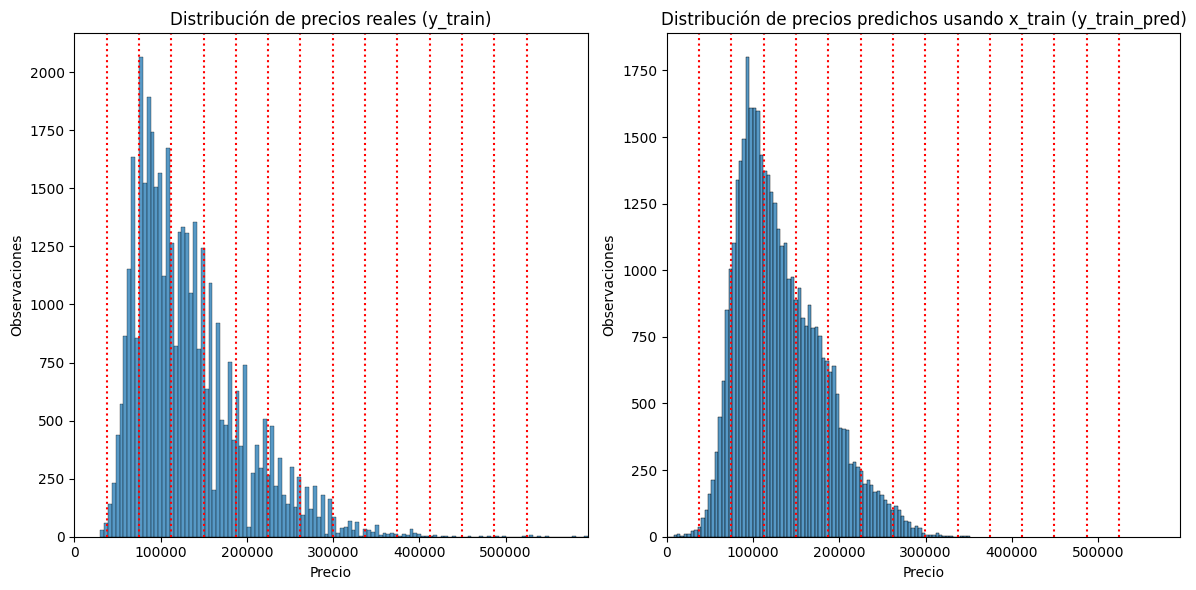

In [219]:
plotear_precios(datos_reales = y_train,
                datos_predichos = y_train_pred,
                rmse = rmse_train,
                titulo_reales = "Distribución de precios reales (y_train)",
                titulo_predichos = "Distribución de precios predichos usando x_train (y_train_pred)")

### Comparamos los resultados con las metricas en train y test

In [220]:
imprimir_comparacion_metricas(r2_test, rmse_test, r2_train, rmse_train)

Resultados contra los datos de test:
  > R2 = 0.6233
  > RMSE = 38775.6268

Resultados contra los datos de train:
  > R2 = 0.636
  > RMSE = 37451.6264


En este caso, tenemos resultados un poco mas desalentadores.

Si bien se mantiene un buen equilibrio entre las metricas de train y test, tenemos resultados inferiores incluso a los obtenidos en KNN al trabajar con los datos de test.

## Elección de modelo para Regresión

En base a los resultados obtenido concluimos que el mejor modelo es XGBoost por los siguientes motivos:

* Tenemos una baja brecha entre las metricas para los datos de train y test.
* Tenemos un buen valor en el error de RMSE
* Tenemos una muy buen valor en la matrica $R^2$